# Reverse image search: Paintings and Painters

This notebook shows an application of reverse image search using CNNs on a kaggle dataset that contains paintings of the 50 most famous painters ([link](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)). Notebook contents:


> 1. Data pre-processing
> 2. Building a classifier of painters based on painting image contents
> 3. Cutting off the head of the classifier and doing EDA on retrieved embeddings
> 4. Using triplet loss and comparing results to logloss
> 5. EDA on triplet loss embeddings



# 0. Data import

In [2]:
# Download data from kaggle
keys = eval(open('kaggle.json', 'r').read())

import os
os.environ['KAGGLE_USERNAME'] = keys["username"]  
os.environ['KAGGLE_KEY'] = keys["key"]

# !kaggle datasets download -d ikarus777/best-artworks-of-all-time

 99% 2.15G/2.16G [00:29<00:00, 74.4MB/s]
100% 2.16G/2.16G [00:29<00:00, 78.1MB/s]


In [0]:
# Import dependencies

# !pip install tensorflow-gpu

import tensorflow as tf
from sklearn.decomposition import PCA

from DLHelper.imports import *
from DLHelper.image import *

from DLHelper.image.utils.RISutils import dataset_to_array, show_distances, show_minmax_emb_images
from DLHelper.image.triplet_loss import pairwise_distance, masked_maximum, masked_minimum, triplet_loss_adapted_from_tf

In [0]:
# DATA_DIR contains train/test data, will contain architectures/weights
DATA_DIR = Path('data/paintings')
TEMP_DIR = Path('temp/paintings')

DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
# Unzip/move data

# !unzip best-artworks-of-all-time.zip
# !mv artists.csv {DATA_DIR/"artists.csv"}
# !unzip -q images.zip -d {DATA_DIR/"train"}
# !mv -v {DATA_DIR/"train/images/*"} {DATA_DIR/"train"}

In [3]:
!cat {DATA_DIR}/artists.csv | head -5

id,name,years,genre,nationality,bio,wikipedia,paintings
0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,"Amedeo Clemente Modigliani (Italian pronunciation: [ameˈdɛːo modiʎˈʎaːni]; 12 July 1884 – 24 January 1920) was an Italian Jewish painter and sculptor who worked mainly in France. He is known for portraits and nudes in a modern style characterized by elongation of faces, necks, and figures that were not received well during his lifetime but later found acceptance. Modigliani spent his youth in Italy, where he studied the art of antiquity and the Renaissance. In 1906 he moved to Paris, where he came into contact with such artists as Pablo Picasso and Constantin Brâncuși. By 1912 Modigliani was exhibiting highly stylized sculptures with Cubists of the Section d'Or group at the Salon d'Automne.",http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,"Wassily Wassilyevich Kandinsky (Russian: Васи́лий Васи́льевич Ка

In [4]:
!ls {DATA_DIR/"train"/"Alfred_Sisley"} | head -5

Alfred_Sisley_100.jpg
Alfred_Sisley_101.jpg
Alfred_Sisley_102.jpg
Alfred_Sisley_103.jpg
Alfred_Sisley_104.jpg


# 1. Data pre-processing
DataRaw contains dataframe with images and labels. This will be passed to DataSplit, which will split the data to train/val tf datasets.

In [0]:
# Initialize dataframe
artists_data_raw = DataRaw(DATA_DIR, filetype="jpg")
artists_data_raw.init_df(y_source='dirnames')

In [5]:
artists_data_raw.df.head(5)

id             label
0  data/paintings/train/Vincent_van_Gogh/Vincent_...  Vincent_van_Gogh
1  data/paintings/train/Vincent_van_Gogh/Vincent_...  Vincent_van_Gogh
2  data/paintings/train/Vincent_van_Gogh/Vincent_...  Vincent_van_Gogh
3  data/paintings/train/Vincent_van_Gogh/Vincent_...  Vincent_van_Gogh
4  data/paintings/train/Vincent_van_Gogh/Vincent_...  Vincent_van_Gogh

In [0]:
label_map = dict(enumerate(os.listdir(DATA_DIR/"train")))
artists_data_raw.label_encode(label_map=label_map)

The data contain 8446 examples of 50 categories. The highest/lowest category counts are 
'Vincent_van_Gogh': 877 and 'Jackson_Pollock': 24


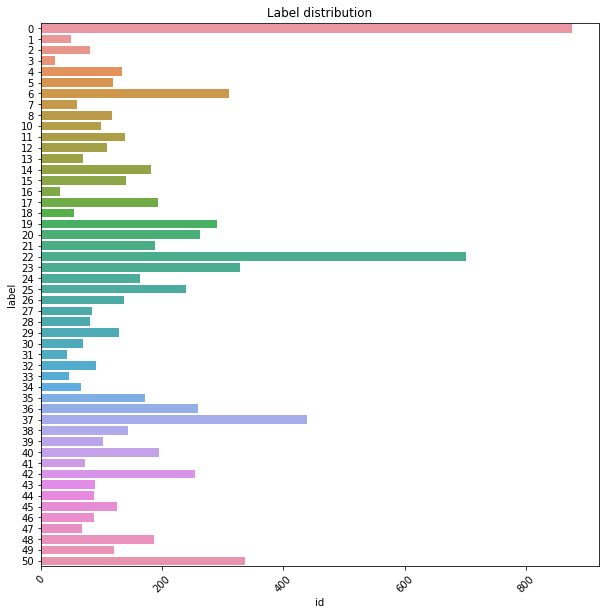

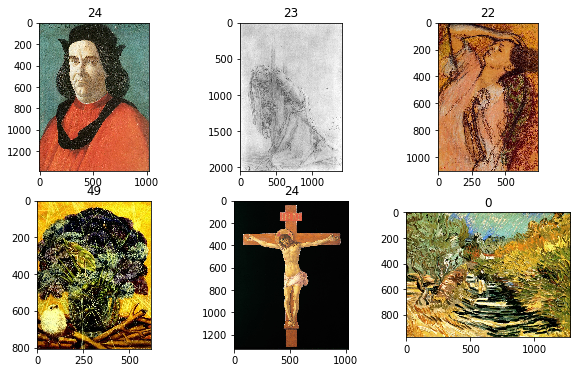

In [7]:
artists_data_raw.describe()

#### *NOTE: Classes are somewhat imbalanced, might require some weighting/resampling. All classes have more than enough examples.

In [0]:
# Create a data split and resize to 150*150
artists_data_split = DataSplit(
    artists_data_raw,
    val_test_size=(0.1,0.0),
    batch_size=16,    
)

In [0]:
artists_data_split.resize(img_dims=(150,150,3), resize="random_crop", crop_adjustment=1.5)

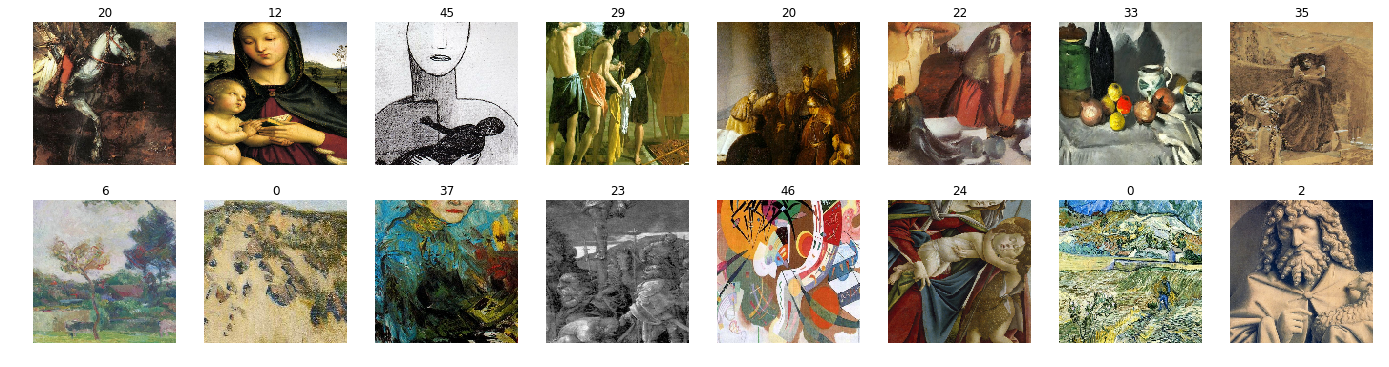

In [10]:
# This is how the resized data looks like
artists_data_split.show()

# 2. Building a painter classifier

The network contains a Dense ("squeeze") layer before the output layer, and uses an Xception with ImageNet weights as the base model. The squeeze layer will contain the embeddings that will later be explored in more detail.

In [0]:
# Build the model
baseline_model = CNNLearner(name="xception_1",
                        path=str(DATA_DIR),
                        data=artists_data_split,
                        base_model=keras.applications.Xception,
                        input_shape=(150,150,3),
                        output_layer=[keras.layers.Dense(
                            len(label_map),
                            kernel_regularizer=keras.regularizers.l1_l2(1e-6, 1e-4),
                            activation=keras.activations.softmax,
                        )],
                        dropout=0.5,
                        load=None)

In [0]:
# Define the squeeze layer and put it in-between the output and concatenation layers 
baseline_model.squeeze_layer = keras.layers.Dense(10, activation=keras.activations.relu, 
                                   kernel_initializer=keras.initializers.he_uniform())
baseline_model.squeeze_bn_layer = keras.layers.BatchNormalization()
baseline_model.new_output_layer = keras.layers.Dense(
                            len(label_map),
                            kernel_regularizer=keras.regularizers.l1_l2(1e-6, 1e-4),
                            activation=keras.activations.softmax,
                        )

# Redefine the model
baseline_model.model = keras.Model(inputs=baseline_model.base_model.input,
                               outputs=baseline_model.new_output_layer(baseline_model.squeeze_bn_layer(
                                   baseline_model.squeeze_layer(baseline_model.branch_1))))


In [13]:
baseline_model.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [0]:
baseline_model.compile(optimizer=keras.optimizers.Adam,
                  lr=1e-4,
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=[keras.metrics.sparse_categorical_accuracy])

#### First run: Small images, no augmentation, no resampling/weights

In [34]:
baseline_model.freeze(3)
baseline_model.fit(2, name="base_frozen_150")

Train for 476 steps, validate for 53 steps
Epoch 1/2
476/476 [==============================] - 189s 397ms/step - loss: 3.6928 - sparse_categorical_accuracy: 0.1345 - val_loss: 3.4389 - val_sparse_categorical_accuracy: 0.2417
Epoch 2/2
476/476 [==============================] - 178s 373ms/step - loss: 3.3009 - sparse_categorical_accuracy: 0.2803 - val_loss: 3.1569 - val_sparse_categorical_accuracy: 0.3396
Note: base_frozen_150 are loaded.


Train for 476 steps
476/476 [==============================] - 168s 353ms/step - loss: 3.3011 - sparse_categorical_accuracy: 0.2756


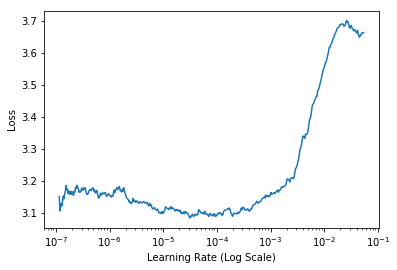

In [35]:
baseline_model.unfreeze()
baseline_model.find_lr()
baseline_model.plot_lr()

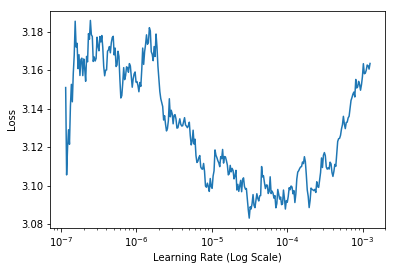

In [36]:
baseline_model.plot_lr(skip_end=150)

In [37]:
baseline_model.unfreeze()
baseline_model.fit(5, lr=(1e-5, 1e-4), name="base_unfrozen_150")

NOTE: Discriminative LR Adam is used.
Train for 476 steps, validate for 53 steps
Epoch 1/5
476/476 [==============================] - 186s 391ms/step - loss: 3.0218 - sparse_categorical_accuracy: 0.3800 - val_loss: 2.9393 - val_sparse_categorical_accuracy: 0.4233
Epoch 2/5
476/476 [==============================] - 176s 370ms/step - loss: 2.7583 - sparse_categorical_accuracy: 0.4529 - val_loss: 2.7364 - val_sparse_categorical_accuracy: 0.4564
Epoch 3/5
476/476 [==============================] - 176s 369ms/step - loss: 2.5097 - sparse_categorical_accuracy: 0.5088 - val_loss: 2.4986 - val_sparse_categorical_accuracy: 0.4894
Epoch 4/5
476/476 [==============================] - 177s 372ms/step - loss: 2.2885 - sparse_categorical_accuracy: 0.5587 - val_loss: 2.4283 - val_sparse_categorical_accuracy: 0.4929
Epoch 5/5
476/476 [==============================] - 177s 371ms/step - loss: 2.0945 - sparse_categorical_accuracy: 0.5928 - val_loss: 2.3293 - val_sparse_categorical_accuracy: 0.5130
Note

#### Second run: Large images, no resampling, no class weights

In [0]:
artists_data_split.resize(img_dims=(299,299,3), resize="random_crop", crop_adjustment=1.25)

In [0]:
baseline_model.previous_weights = None
baseline_model.recompile(input_shape=(299,299,3), load=None)

baseline_model.model = keras.Model(inputs=baseline_model.base_model.input,
                               outputs=baseline_model.new_output_layer(baseline_model.squeeze_bn_layer(
                                   baseline_model.squeeze_layer(baseline_model.branch_1))))

In [27]:
baseline_model.load("base_unfrozen_299")

baseline_model.compile(optimizer=keras.optimizers.Adam,
                  lr=1e-4,
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=[keras.metrics.sparse_categorical_accuracy])

Note: base_unfrozen_299 are loaded.


In [17]:
baseline_model.freeze(3)
baseline_model.fit(2, name="base_frozen_299")

Train for 476 steps, validate for 53 steps
Epoch 1/2
476/476 [==============================] - 639s 1s/step - loss: 2.0082 - sparse_categorical_accuracy: 0.5978 - val_loss: 1.6361 - val_sparse_categorical_accuracy: 0.6840
Epoch 2/2
476/476 [==============================] - 621s 1s/step - loss: 1.6712 - sparse_categorical_accuracy: 0.6917 - val_loss: 1.5528 - val_sparse_categorical_accuracy: 0.6922
Note: base_frozen_299 are loaded.


In [18]:
baseline_model.unfreeze()
baseline_model.fit(5, lr=(1e-6, 1e-4), name="base_unfrozen_299")

NOTE: Discriminative LR Adam is used.
Train for 476 steps, validate for 53 steps
Epoch 1/5
476/476 [==============================] - 645s 1s/step - loss: 1.4553 - sparse_categorical_accuracy: 0.7354 - val_loss: 1.5153 - val_sparse_categorical_accuracy: 0.7087
Epoch 2/5
476/476 [==============================] - 622s 1s/step - loss: 1.2762 - sparse_categorical_accuracy: 0.7765 - val_loss: 1.3958 - val_sparse_categorical_accuracy: 0.7358
Epoch 3/5
476/476 [==============================] - 622s 1s/step - loss: 1.1307 - sparse_categorical_accuracy: 0.8107 - val_loss: 1.3438 - val_sparse_categorical_accuracy: 0.7382
Epoch 4/5
476/476 [==============================] - 623s 1s/step - loss: 0.9989 - sparse_categorical_accuracy: 0.8414 - val_loss: 1.2253 - val_sparse_categorical_accuracy: 0.7547
Epoch 5/5
476/476 [==============================] - 623s 1s/step - loss: 0.8913 - sparse_categorical_accuracy: 0.8674 - val_loss: 1.1906 - val_sparse_categorical_accuracy: 0.7889
Note: base_unfrozen

#### Third run: Large images + augmentation

In [0]:
flipper = Augmentor(h_flip=0.5, brightness=(0.5, 0.1), contrast=(0.5, 0.1))
artists_data_split.reaugment(flipper)

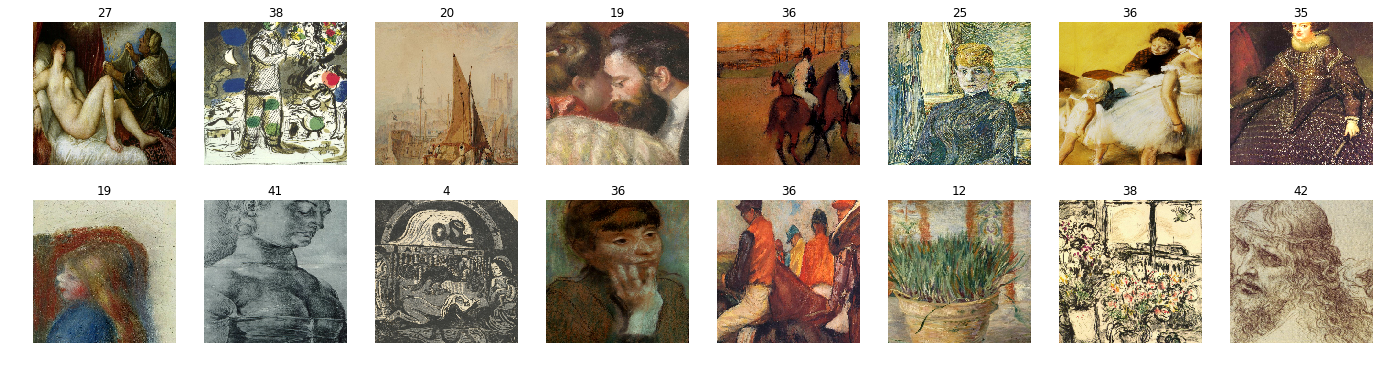

In [22]:
artists_data_split.show()

In [23]:
baseline_model.fit(5, lr=(1e-6, 7e-5), name="base_unfrozen_299")

NOTE: Discriminative LR Adam is used.
Train for 476 steps, validate for 53 steps
Epoch 1/5
476/476 [==============================] - 632s 1s/step - loss: 0.8909 - sparse_categorical_accuracy: 0.8578 - val_loss: 1.1360 - val_sparse_categorical_accuracy: 0.7948
Epoch 2/5
476/476 [==============================] - 618s 1s/step - loss: 0.7856 - sparse_categorical_accuracy: 0.8863 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.7913
Epoch 3/5
476/476 [==============================] - 617s 1s/step - loss: 0.7086 - sparse_categorical_accuracy: 0.9019 - val_loss: 1.0378 - val_sparse_categorical_accuracy: 0.7972
Epoch 4/5
476/476 [==============================] - 616s 1s/step - loss: 0.6419 - sparse_categorical_accuracy: 0.9157 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.8090
Epoch 5/5
476/476 [==============================] - 617s 1s/step - loss: 0.5806 - sparse_categorical_accuracy: 0.9294 - val_loss: 1.0083 - val_sparse_categorical_accuracy: 0.8090
Note: base_unfrozen

#### Fourth run: add class weights

In [24]:
baseline_model.fit(2, lr=(1e-6, 7e-5), name="base_unfrozen_299", class_weights=True)

NOTE: Discriminative LR Adam is used.
Train for 476 steps, validate for 53 steps
Epoch 1/2
476/476 [==============================] - 641s 1s/step - loss: 0.5243 - sparse_categorical_accuracy: 0.9383 - val_loss: 0.9740 - val_sparse_categorical_accuracy: 0.8101
Epoch 2/2
476/476 [==============================] - 625s 1s/step - loss: 0.4878 - sparse_categorical_accuracy: 0.9404 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.8255
Note: base_unfrozen_150 are loaded.


#### Fifth run: add upsampling of small classes

In [0]:
baseline_model.data = DataSplit(
    artists_data_raw,
    val_test_size=(0.1,0.0),
    batch_size=16,    
    aug=flipper,
    upsample=0.05
)
baseline_model.data.resize(img_dims=(299,299,3), resize="random_crop", crop_adjustment=1.25)

In [38]:
baseline_model.fit(3, lr=(1e-6, 7e-5), name="base_unfrozen_299", class_weights=True)

NOTE: Discriminative LR Adam is used.
Train for 575 steps, validate for 53 steps
Epoch 1/3
575/575 [==============================] - 750s 1s/step - loss: 0.3964 - sparse_categorical_accuracy: 0.9550 - val_loss: 0.2785 - val_sparse_categorical_accuracy: 0.9623
Epoch 2/3
575/575 [==============================] - 737s 1s/step - loss: 0.3496 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.2769 - val_sparse_categorical_accuracy: 0.9611
Epoch 3/3
575/575 [==============================] - 735s 1s/step - loss: 0.3045 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9741
Note: base_unfrozen_299 are loaded.


# Classifier: final results

Overall accuracy: 97.41%
<br>Lowest label category F1: 0.8

In [0]:
# category_accs = baseline_model.acc_report()
f1 = {k: v['f1-score'] for (k,v) in category_accs.items() if (k != "accuracy") & \
      (k != 'macro avg') & (k != 'weighted avg')}
N  = {k: v['support'] for (k,v) in category_accs.items() if (k != "accuracy") & \
      (k != 'macro avg') & (k != 'weighted avg')}

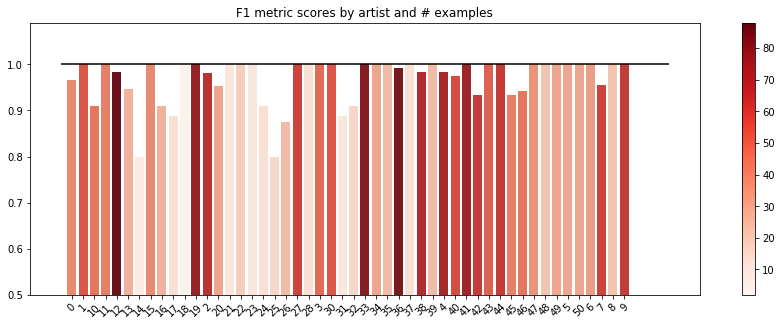

In [106]:
plt.figure(figsize=(15,5))
plot = plt.scatter(list(f1.keys()), list(f1.values()), c=list(N.values()), 
                   cmap='Reds')
plt.clf()
plt.colorbar(plot)

ax = sns.barplot(x=list(f1.keys()), y=list(f1.values()), hue=list(N.values()), 
            palette='Reds', dodge=False)
ax.set_ylim(0.5,1.09)
ax.tick_params(axis='x', rotation=45)
ax.set_title("F1 metric scores by artist and # examples")
ax.hlines(1., -1, 53)
ax.legend_.remove()
plt.show()

# 3. Exploring results of the classifier's embeddings

Let's cut the output layer of the classifier and see what information the embeddings contain.

In [0]:
# Cut the output layer
baseline_model.model = keras.Model(
    inputs=baseline_model.base_model.input,
    outputs=baseline_model.squeeze_layer(baseline_model.branch_1),
)

In [0]:
# Let's use all the data to make it more fun
artists_data_split = DataSplit(
    artists_data_raw,
    val_test_size=(0.001,0.0),
    batch_size=16,    
    aug=None,
)
artists_data_split.resize(img_dims=(299,299,3), resize="stretch")

### Neighbour-search
We can use the embeddings to score each image and find the closest (most similar) images. Based on the classifier's labels, these should be paintings of the same painter (or a copy-cat!).

In [0]:
xs, ys = dataset_to_array(artists_data_split.train, 150)
image_embeddings = baseline_model.model.predict(xs)
nbrs = sk.neighbors.NearestNeighbors(n_neighbors=11, algorithm="ball_tree").fit(
    image_embeddings
)

In [0]:
new_prepared_image = xs[2386:2387]
new_image_embeddings = baseline_model.model.predict(new_prepared_image)
distances, indices = nbrs.kneighbors(new_image_embeddings)

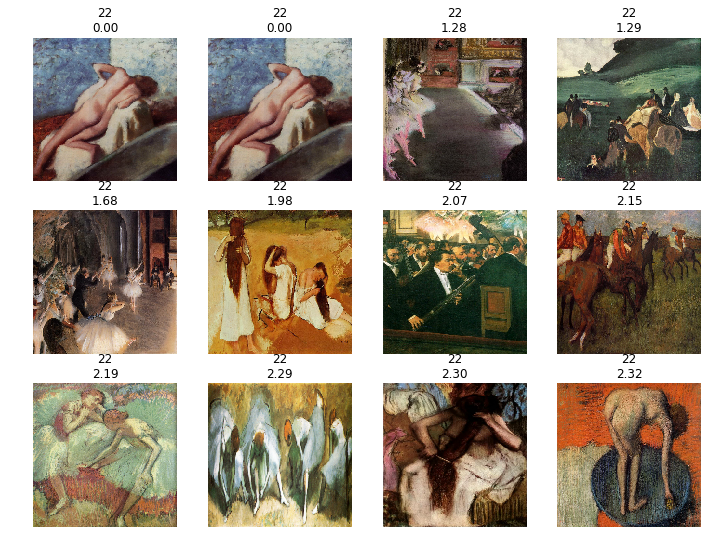

In [22]:
show_distances(
    xs,
    ys,
    2386,
    indices[0].tolist(),
    distances[0].tolist(),
)

### Principal component analysis

We used embeddings of 10 (neurons), which store 10 aspects of paintings that differentiate the painters best. These embeddings can actually be compressed further and visualized in a 2-dimensional space, where the 2 dimensions capture most of the information in the 10 embedding solution.

In [0]:
# Create a PCA model with 2 components
pca = PCA(n_components=2)

# Run the PCA on image embeddings from our baseline model
components = pca.fit_transform(image_embeddings)

# Create a dataframe with component scores (10 embeddings -> 2 components ("embeddings"))
component_df = pd.DataFrame(components)

# Add labels to an extra column
component_df = pd.concat([component_df, pd.Series(ys)], axis = 1)

# Column names
component_df.columns = ['pc1', 'pc2', 'label']

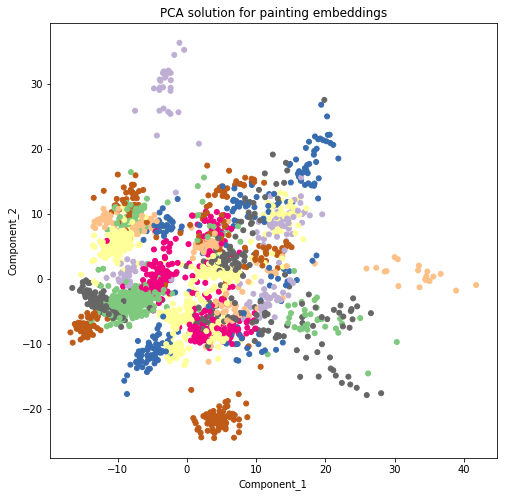

In [24]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component_1')
ax.set_ylabel('Component_2')
ax.set_title('PCA solution for painting embeddings')
ax.scatter(component_df.loc[:, 'pc1'], 
           component_df.loc[:, 'pc2'], 
           c = component_df['label'], s = 25, cmap='Accent')
plt.show()

### Can we understand what features of paintings the model stores in embeddings?
Let's see the paintings with highest and lowest values for some of the extracted embeddings

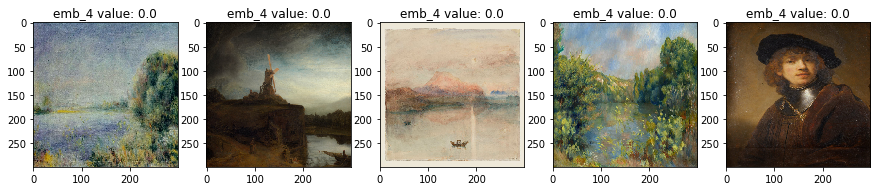

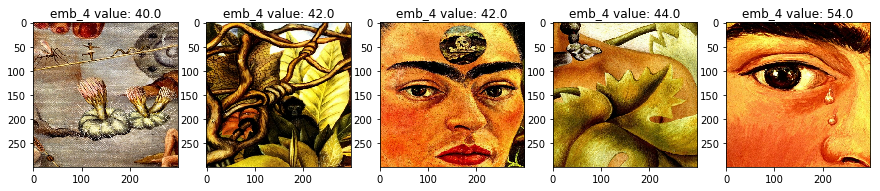

In [46]:
# Create a dataframe with embeddings scores for each image
embeddings_df = pd.DataFrame(image_embeddings)
embeddings_df.columns = ["emb_0", "emb_1", "emb_2", "emb_3", "emb_4", "emb_5", 
                        "emb_6", "emb_7", "emb_8", "emb_9"]

# Let's see some embeddings
show_minmax_emb_images(embeddings_df, "emb_4", xs)

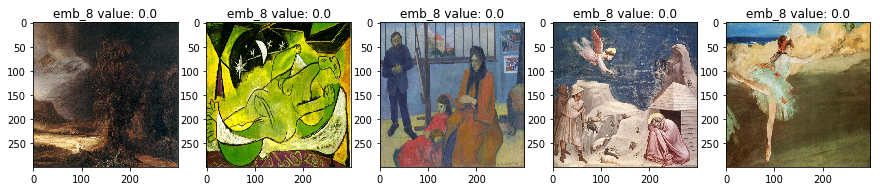

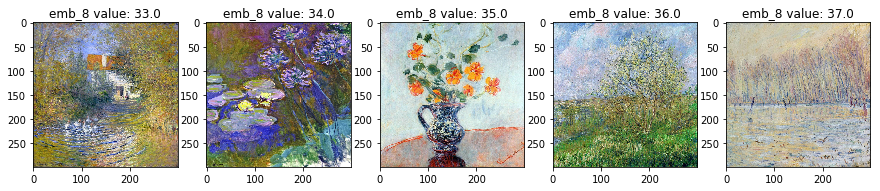

In [28]:
show_minmax_emb_images(embeddings_df, "emb_8", xs)

NOTE: Although values on 10 embeddings can be used to predict the painter with 97%+ accuracy, it is pretty difficult to eyeball what these features stored in embeddings really are.

### Can painting similarity reveal anything about painting genres? 
Let's color the triplet loss PCA solution by genre

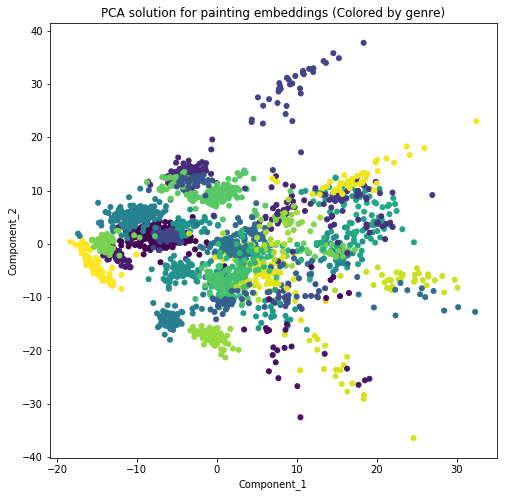

In [54]:
# Convert labels back to author names using label map and use artists.csv
# to fetch genre's of each painter
component_df["author_name"] = component_df.label.map(label_map)
author_info = pd.read_csv(DATA_DIR/'artists.csv')

# Replace spaces with underscores (to match labels)
author_info["author_name"] = author_info.name.map(lambda x: x.replace(' ', '_'))
component_df = component_df.merge(author_info, on="author_name")

# Some authors have multiple genres. Let's pick the first one for each
component_df["genre"] = component_df.genre.map(lambda x: x.split(',')[0])

# Encode genres
le = LabelEncoder()
component_df["genre_encoded"] = le.fit(component_df.genre).transform(component_df.genre)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Component_1')
ax.set_ylabel('Component_2')
ax.set_title('PCA solution for painting embeddings (Colored by genre)')
ax.scatter(component_df.loc[:, 'pc1'], 
           component_df.loc[:, 'pc2'], 
           c = component_df['label'], s = 25)
plt.show()

#### Maybe we can find something out about embeddings based on painters' mean scores?

Disclaimer: Not really.

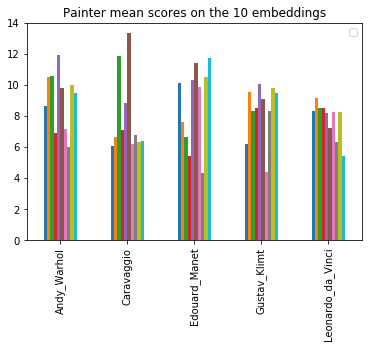

In [75]:
authors = pd.concat([embeddings_df, component_df], axis=1)

(authors.loc[(authors["author_name"]=="Caravaggio") | (authors["author_name"]=="Andy_Warhol") | 
             (authors["author_name"]=="Edouard_Manet") | (authors["author_name"]=="Gustav_Klimt") | 
             (authors["author_name"]=="Leonardo_da_Vinci"),:]
 .groupby('author_name')["emb_0", "emb_1", "emb_2", "emb_3", "emb_4", "emb_5", "emb_6", "emb_7", "emb_8", "emb_9"]
 .mean()
 .plot(kind="bar"))
plt.legend('')
plt.title('Painter mean scores on the 10 embeddings')
plt.xlabel('')
plt.show()

# 4. Triplet loss training

Here a model with 16-size embedding layer is trained from scratch using triplet loss. There seems to be something wrong with this dataset/loss combination, since loss sometimes goes to nan in the middle of the training.

Due to a lack of time, I trained on 100x100 images.

In [17]:
baseline_model.data = DataSplit(
    artists_data_raw,
    val_test_size=(0.1,0.0),
    batch_size=16,    
    aug=flipper,
    upsample=0.05
)

baseline_model.data.resize(img_dims=(299,299,3), resize="random_crop", crop_adjustment=1.25)

baseline_model.model = keras.Model(
    inputs=baseline_model.base_model.input,
    outputs=keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(
        keras.layers.Dense(16, activation=None)(baseline_model.branch_1)
    ),
)

baseline_model.compile(optimizer=partial(tf.keras.optimizers.Adam, clipvalue=0.5), lr=1e-5,
                      loss=triplet_loss_adapted_from_tf)

baseline_model.fit(3, lr=(1e-6, 5e-5), name="triplet_unfrozen_299", class_weights=True)

Instructions for updating:
Use `tf.cast` instead.
NOTE: Discriminative LR Adam is used.
Train for 575 steps, validate for 53 steps
Epoch 1/3
575/575 [==============================] - 748s 1s/step - loss: 1.4143 - val_loss: 1.0246
Epoch 2/3
575/575 [==============================] - 729s 1s/step - loss: 1.0512 - val_loss: 1.0116
Epoch 3/3
  2/575 [..............................] - ETA: 11:45 - loss: 1.0214WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: ignored

# 5. Comparison of logloss vs triplet loss: EDA

Let's first run the PCA on triplet loss embeddings again and compare the plots

In [0]:
# Let's get the embeddings again, this time from the triplet model
xs, ys = dataset_to_array(baseline_model.data.val, 53)
image_embeddings = baseline_model.model.predict(xs)

In [0]:
# Create a PCA model with 2 components again
pca = PCA(n_components=2)

# Run the PCA on image embeddings from the triplet
components = pca.fit_transform(image_embeddings)

# Create a dataframe with component scores (10 embeddings -> 2 components ("embeddings"))
triple_component_df = pd.DataFrame(components)

# Add labels to an extra column
triple_component_df = pd.concat([triple_component_df, pd.Series(ys)], axis = 1)

# Column names
triple_component_df.columns = ['pc1', 'pc2', 'label']

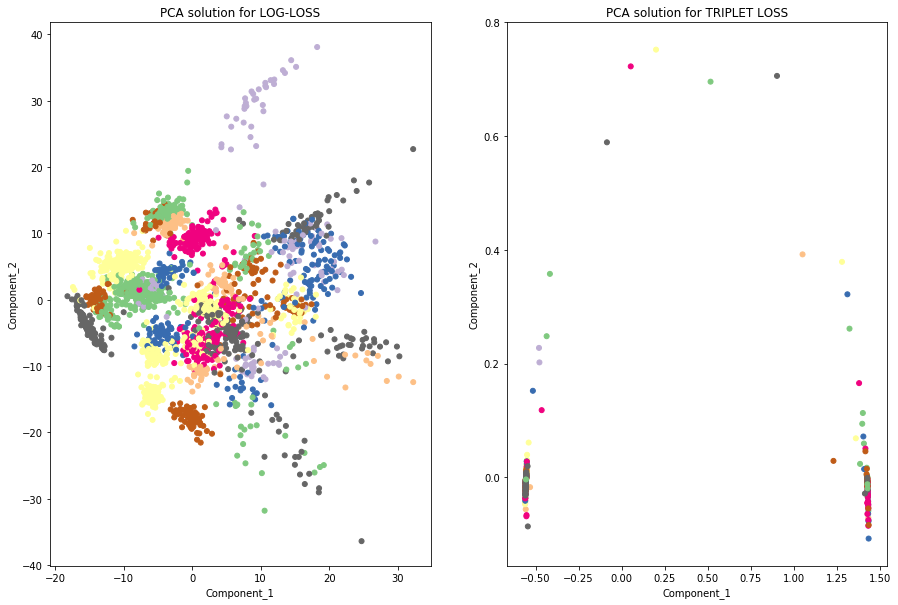

In [36]:
# Compare the twe log-loss PCA and triplet-loss PCA

_, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].scatter(component_df.loc[:, 'pc1'], 
              component_df.loc[:, 'pc2'], 
              c = component_df['label'], s = 25, cmap='Accent')
ax[0].set_xlabel('Component_1')
ax[0].set_ylabel('Component_2')
ax[0].set_title('PCA solution for LOG-LOSS')

ax[1].scatter(triple_component_df.loc[:, 'pc1'], 
              triple_component_df.loc[:, 'pc2'], 
              c = triple_component_df['label'], s = 25, cmap='Accent')
ax[1].set_xlabel('Component_1')
ax[1].set_ylabel('Component_2')
ax[1].set_title('PCA solution for TRIPLET LOSS')

plt.show()